In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# Define las transformaciones
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Descarga y carga los datos de MNIST
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
# Definir las transformaciones (convertir a tensor y normalizar)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Descargar y cargar los datos de entrenamiento
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Descargar y cargar los datos de prueba
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [5]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # Capa oculta con 128 neuronas
        self.fc2 = nn.Linear(128, 10)       # Capa de salida con 10 neuronas (una para cada dígito)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Aplana la imagen de 28x28 píxeles en un vector de 784 elementos
        x = F.relu(self.fc1(x))  # Activación ReLU en la capa oculta
        x = self.fc2(x)          # Capa de salida
        return x

# Instanciar el modelo
model = SimpleNN()

In [11]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Entrenar el modelo por 2 épocas
for epoch in range(2):
    running_loss = 0.0
    for inputs, labels in trainloader:
        optimizer.zero_grad()           # Limpiar los gradientes
        outputs = model(inputs)         # Forward pass
        loss = criterion(outputs, labels) # Calcular la pérdida
        loss.backward()                 # Backward pass
        optimizer.step()                # Actualizar los pesos

        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

Epoch 1, Loss: 0.3489073997934659
Epoch 2, Loss: 0.17444983156323432


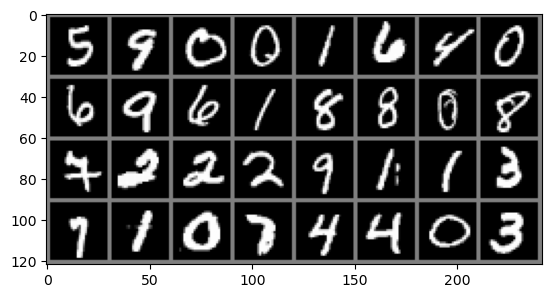

Labels: 5 9 0 0 1 6 4 0


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Función para mostrar una imagen
def imshow(img):
    img = img / 2 + 0.5  # Desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Obtener un lote de imágenes
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Mostrar algunas imágenes
imshow(torchvision.utils.make_grid(images))
print('Labels:', ' '.join(f'{labels[j].item()}' for j in range(8)))

In [26]:
import boto3
import os

# Configura tu bucket y nombre de la carpeta
bucket_name = 'buchetchan'
folder_prefix = 'carpeta3'

# Conectar a S3
s3 = boto3.client('s3')

# Listar los objetos en la carpeta
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder_prefix)

# Descargar cada archivo en la carpeta
local_folder = '/tmp/imagenes_extraidas'
os.makedirs(local_folder, exist_ok=True)

for obj in response.get('Contents', []):
    key = obj['Key']
    if key.endswith('/'):  # Ignorar carpetas (si hay)
        continue
    local_file_path = os.path.join(local_folder, os.path.basename(key))
    s3.download_file(bucket_name, key, local_file_path)

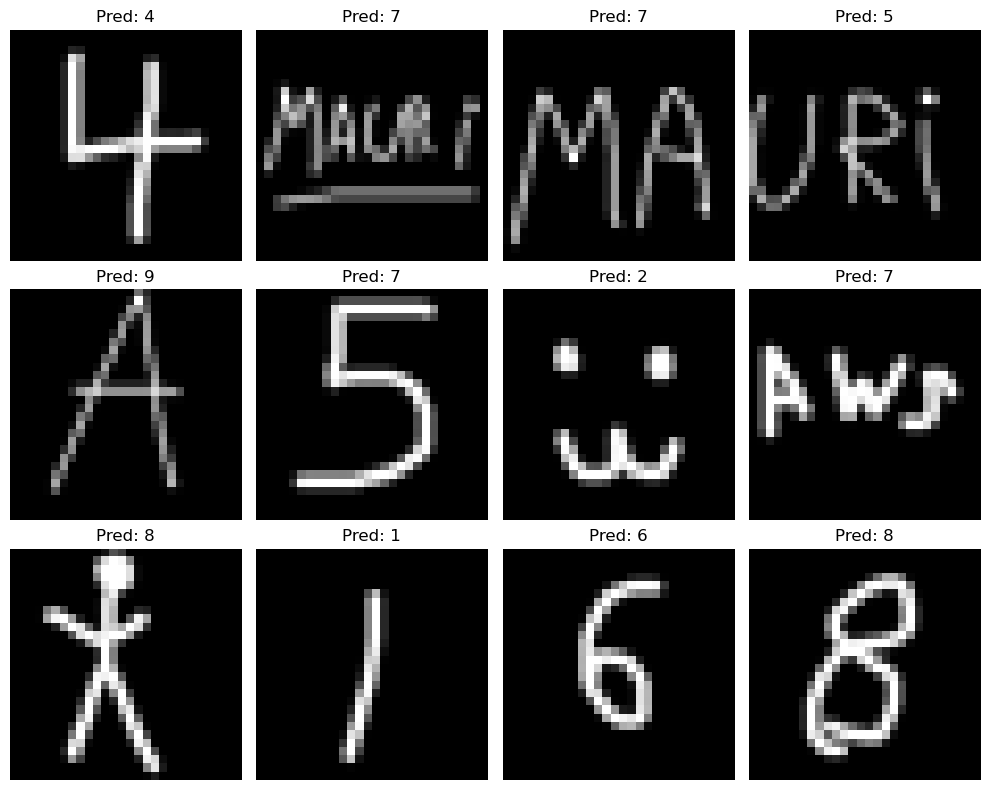

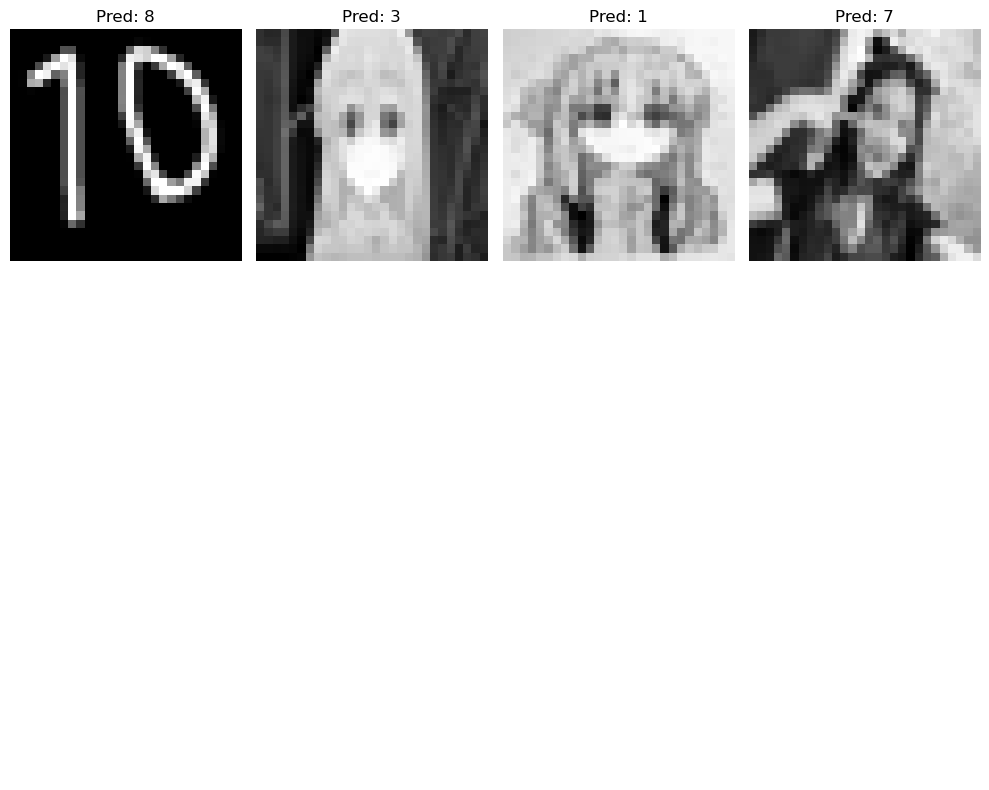

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import os

# Función para cargar y procesar la imagen
def load_and_process_image(img_path):
    img = Image.open(img_path).convert('L')  # Convertir a escala de grises
    img = img.resize((28, 28))  # Redimensionar a 28x28
    img_tensor = transform(img).unsqueeze(0)
    return img, img_tensor

# Función para mostrar las imágenes en cuadrículas de 3x4
def show_image_grid(images, preds, rows=3, cols=4):
    num_images = len(images)
    
    for start in range(0, num_images, rows * cols):
        # Crear una cuadrícula de 3x4 (12 imágenes por cuadrícula)
        fig, axes = plt.subplots(rows, cols, figsize=(10, 8))
        for i in range(rows * cols):
            img_index = start + i
            if img_index >= num_images:
                axes[i // cols, i % cols].axis('off')
                continue
            img, pred = images[img_index], preds[img_index]
            axes[i // cols, i % cols].imshow(img, cmap='gray')
            axes[i // cols, i % cols].set_title(f'Pred: {pred}', fontsize=12)
            axes[i // cols, i % cols].axis('off')
        
        plt.tight_layout()
        plt.show()

# Configura la transformación para normalizar las imágenes
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Directorio de las imágenes descargadas
local_folder = '/tmp/imagenes_extraidas'

# Listas para almacenar las imágenes y predicciones
images = []
preds = []

# Procesar cada imagen en la carpeta
for img_file in os.listdir(local_folder):
    img_path = os.path.join(local_folder, img_file)
    img, img_tensor = load_and_process_image(img_path)
    
    # Añadir la imagen a la lista
    images.append(img)

    # Realizar la predicción
    model.eval()
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)
    preds.append(predicted.item())

# Mostrar las imágenes en cuadrículas de 12 por página
show_image_grid(images, preds)


In [18]:
s3_folders = ['carpeta3/personitas/', 'carpeta3/capibaras/']

for folder in s3_folders:
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder)

    if 'Contents' in response:
        for obj in response['Contents']:
            s3_file_path = obj['Key']
            if not s3_file_path.endswith('/'):  # Evitar directorios
                local_file_path = os.path.join(local_folder, os.path.basename(s3_file_path))
                s3.download_file(bucket_name, s3_file_path, local_file_path)
    else:
        print(f'No se encontraron archivos en el bucket {bucket_name} con el prefijo {folder}')


No se encontraron archivos en el bucket buchetchan con el prefijo carpeta3/personitas/
No se encontraron archivos en el bucket buchetchan con el prefijo carpeta3/capibaras/


In [19]:
import boto3
from botocore.exceptions import ClientError

s3 = boto3.client('s3')
bucket_name = 'nombre-del-bucket'  # Reemplaza con tu nombre de bucket

try:
    response = s3.list_objects_v2(Bucket=bucket_name)
    print("Acceso a la lista de objetos exitoso.")
except ClientError as e:
    print(f"Error: {e}")

Error: An error occurred (AccessDenied) when calling the ListObjectsV2 operation: Access Denied


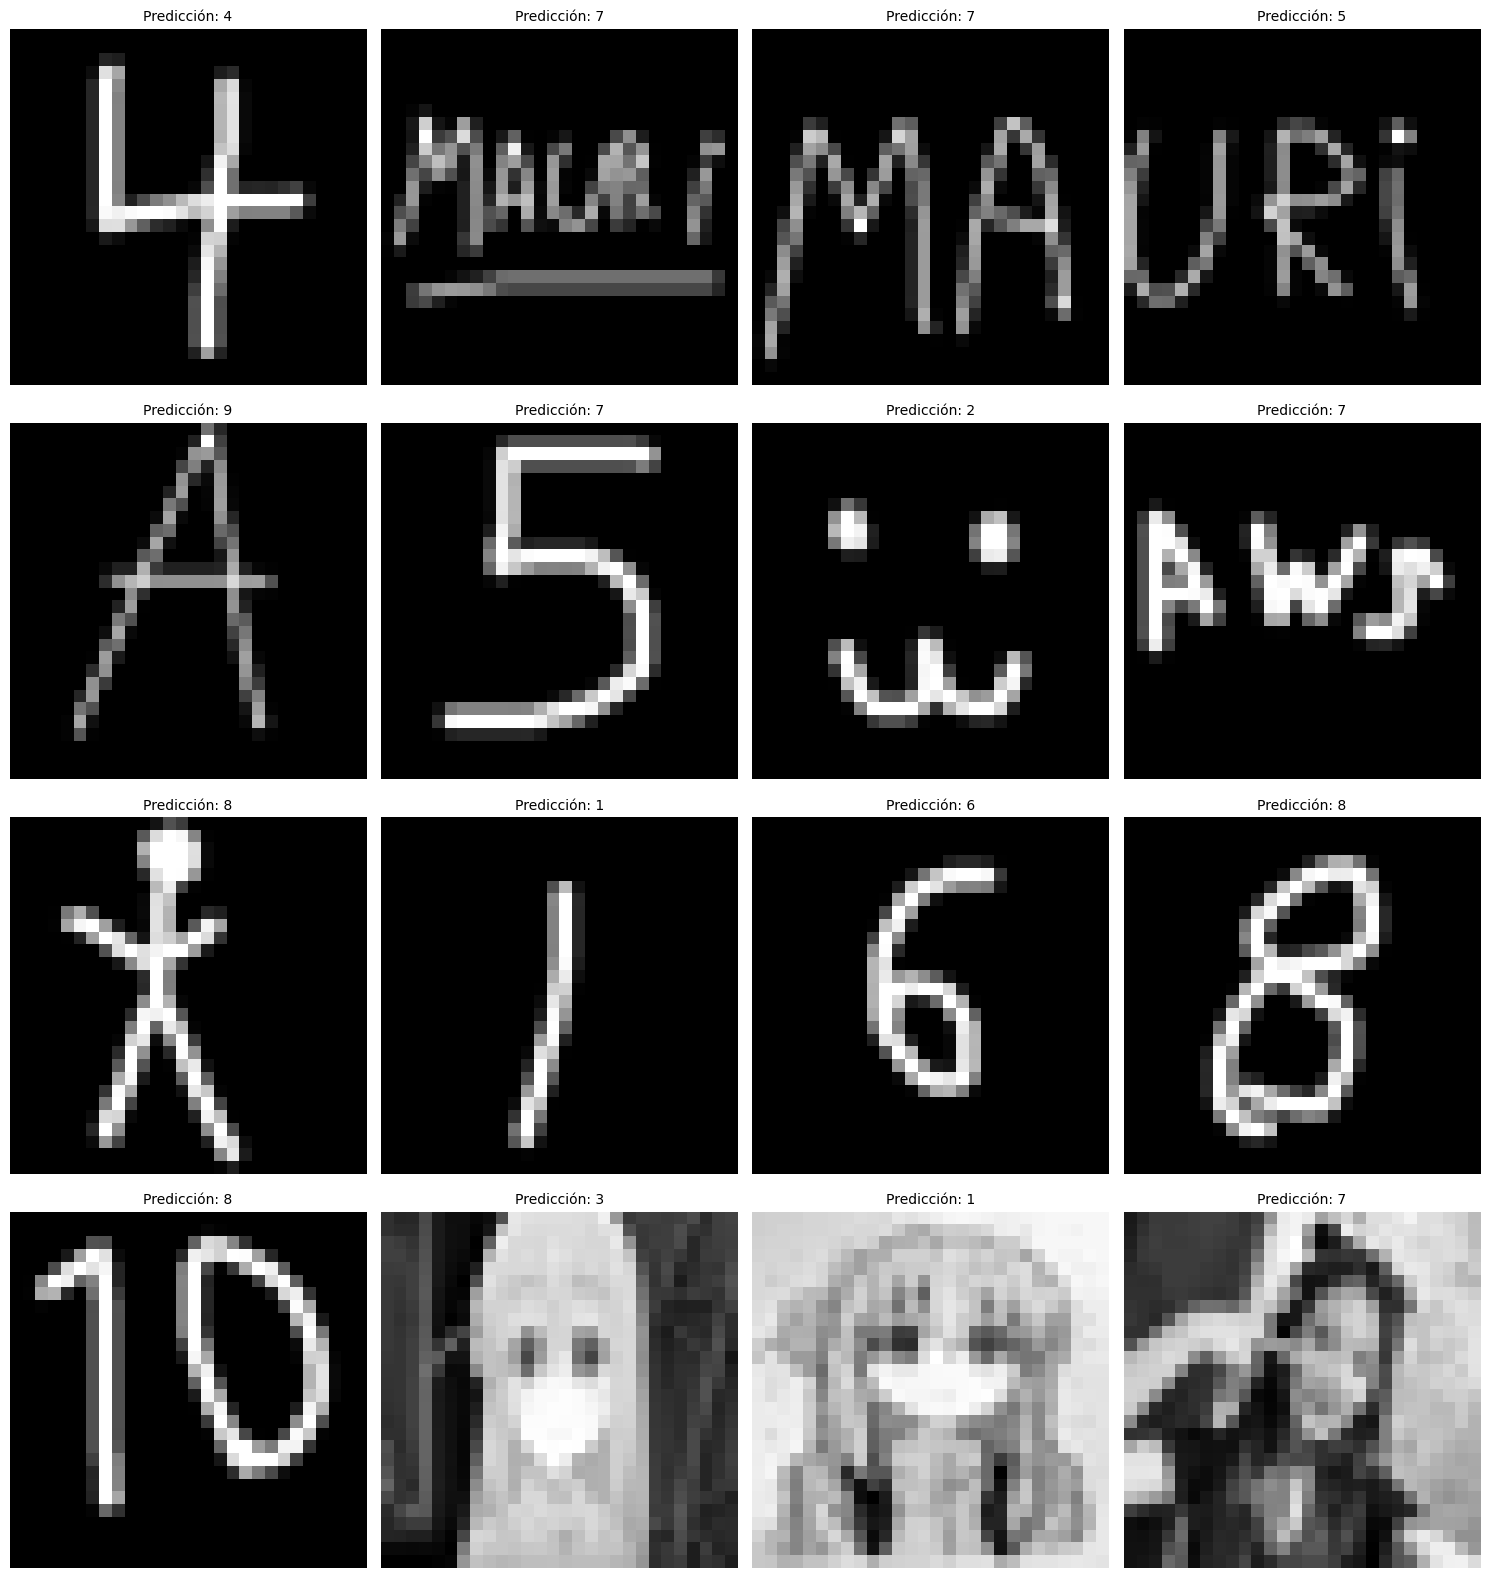

In [20]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import os
import torch

# Función para cargar y procesar la imagen
def load_and_process_image(img_path):
    img = Image.open(img_path).convert('L')  # Convertir a escala de grises
    img = img.resize((28, 28))  # Redimensionar a 28x28
    img_tensor = transform(img).unsqueeze(0)
    return img, img_tensor

# Función para mostrar una cuadrícula de imágenes
def show_image_grid(images, preds):
    num_images = len(images)
    num_cols = 4
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
    axes = axes.flatten()
    for i, (img, pred) in enumerate(zip(images, preds)):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Predicción: {pred}', fontsize=10)
        axes[i].axis('off')
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

# Configura la transformación para normalizar las imágenes
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

local_folder = '/tmp/imagenes_extraidas'

images = []
preds = []

for img_file in os.listdir(local_folder):
    img_path = os.path.join(local_folder, img_file)
    img, img_tensor = load_and_process_image(img_path)
    
    # Mostrar la imagen
    images.append(img)

    # Predicción
    model.eval()
    img_tensor = img_tensor.to('cpu')  # Asegúrate de que esté en CPU
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)
    preds.append(predicted.item())

show_image_grid(images, preds)


In [22]:
import os

train_dir = '/tmp/imagenes_extraidas/train'
test_dir = '/tmp/imagenes_extraidas/test'

print("Archivos en el directorio de entrenamiento:")
print(os.listdir(train_dir))

print("Archivos en el directorio de prueba:")
print(os.listdir(test_dir))


Archivos en el directorio de entrenamiento:


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/imagenes_extraidas/train'

In [31]:
import boto3
import os

s3 = boto3.client('s3')
bucket_name = 'buchetchan'
s3_folders = ['carpeta3/personitas/', 'carpeta3/capibaras/']
local_base_dir = '/tmp/imagenes_extraidas/'

for folder in s3_folders:
    local_folder = os.path.join(local_base_dir, folder.split('/')[1])
    os.makedirs(local_folder, exist_ok=True)

    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder)

    if 'Contents' in response:
        for obj in response['Contents']:
            s3_file_path = obj['Key']
            if not s3_file_path.endswith('/'):  # Evitar directorios
                local_file_path = os.path.join(local_folder, os.path.basename(s3_file_path))
                s3.download_file(bucket_name, s3_file_path, local_file_path)
                print(f'Descargado {local_file_path}')
    else:
        print(f"No se encontraron archivos en {folder}")


No se encontraron archivos en carpeta3/personitas/
No se encontraron archivos en carpeta3/capibaras/


In [28]:
import os

# Definir rutas
train_dir = '/tmp/imagenes_extraidas/train'
test_dir = '/tmp/imagenes_extraidas/test'

# Crear directorios si no existen
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

print("Directorios creados o ya existentes:")
print(f"Entrenamiento: {os.listdir('/tmp/imagenes_extraidas')}")


Directorios creados o ya existentes:
Entrenamiento: ['1.png', '10.png', '11.png', '12.png', '13.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png', 'bocchi-the-rock-anime-1.jpg', 'images.jpg', 'kurachireo-1694647602657325319-20230824_054728-img1.jpg', 'personitas', 'train', 'test', 'carpeta3']


In [40]:
import os

# Nuevas rutas de directorios
train_dir = '/tmp/imagenes_extraidas/Carpeta3'
test_dir = '/tmp/imagenes_extraidas/Carpeta3/capibaras'

# Crear directorios si no existen
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Verificar directorios
print("Archivos en el directorio de entrenamiento:")
print(os.listdir(train_dir))

print("Archivos en el directorio de prueba:")
print(os.listdir(test_dir))


Archivos en el directorio de entrenamiento:
['personitas', 'capibaras']
Archivos en el directorio de prueba:
[]


In [33]:
response = s3.list_objects_v2(Bucket=bucket_name, Prefix='Carpeta3')
for obj in response.get('Contents', []):
    print(obj['Key'])


Carpeta3/capibaras/1.png
Carpeta3/capibaras/10.png
Carpeta3/capibaras/11.png
Carpeta3/capibaras/12.png
Carpeta3/capibaras/13.png
Carpeta3/capibaras/14.png
Carpeta3/capibaras/15.png
Carpeta3/capibaras/16.png
Carpeta3/capibaras/17.png
Carpeta3/capibaras/18.png
Carpeta3/capibaras/19.png
Carpeta3/capibaras/2.png
Carpeta3/capibaras/20.png
Carpeta3/capibaras/21.png
Carpeta3/capibaras/22.png
Carpeta3/capibaras/23.png
Carpeta3/capibaras/24.png
Carpeta3/capibaras/25.png
Carpeta3/capibaras/26.png
Carpeta3/capibaras/27.png
Carpeta3/capibaras/28.png
Carpeta3/capibaras/29.png
Carpeta3/capibaras/3.png
Carpeta3/capibaras/30.png
Carpeta3/capibaras/31.png
Carpeta3/capibaras/32.png
Carpeta3/capibaras/33.png
Carpeta3/capibaras/34.png
Carpeta3/capibaras/35.png
Carpeta3/capibaras/36.png
Carpeta3/capibaras/37.png
Carpeta3/capibaras/38.png
Carpeta3/capibaras/39.png
Carpeta3/capibaras/4.png
Carpeta3/capibaras/40.png
Carpeta3/capibaras/41.png
Carpeta3/capibaras/42.png
Carpeta3/capibaras/43.png
Carpeta3/capibar

In [43]:
import boto3
import os

s3 = boto3.client('s3')
bucket_name = 'buchetchan'
s3_folders = ['Carpeta3/personitas/', 'Carpeta3/capibaras/']
local_base_dir = '/tmp/imagenes_extraidas/'

# Crear directorios locales si no existen
os.makedirs(local_base_dir, exist_ok=True)

for folder in s3_folders:
    local_folder = os.path.join(local_base_dir, folder.split('/')[1])
    os.makedirs(local_folder, exist_ok=True)

    # Listar y descargar archivos desde S3
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=folder)
    if 'Contents' in response:
        for obj in response['Contents']:
            s3_file_path = obj['Key']
            if not s3_file_path.endswith('/'):  # Evitar directorios
                local_file_path = os.path.join(local_folder, os.path.basename(s3_file_path))
                s3.download_file(bucket_name, s3_file_path, local_file_path)
                print(f'Descargado {local_file_path}')
    else:
        print(f"No se encontraron archivos en {folder}")


Descargado /tmp/imagenes_extraidas/personitas/1.png
Descargado /tmp/imagenes_extraidas/personitas/10.png
Descargado /tmp/imagenes_extraidas/personitas/11.png
Descargado /tmp/imagenes_extraidas/personitas/12.png
Descargado /tmp/imagenes_extraidas/personitas/13.png
Descargado /tmp/imagenes_extraidas/personitas/14.png
Descargado /tmp/imagenes_extraidas/personitas/15.png
Descargado /tmp/imagenes_extraidas/personitas/16.png
Descargado /tmp/imagenes_extraidas/personitas/17.png
Descargado /tmp/imagenes_extraidas/personitas/18.png
Descargado /tmp/imagenes_extraidas/personitas/19.png
Descargado /tmp/imagenes_extraidas/personitas/2.png
Descargado /tmp/imagenes_extraidas/personitas/20.png
Descargado /tmp/imagenes_extraidas/personitas/21.png
Descargado /tmp/imagenes_extraidas/personitas/22.png
Descargado /tmp/imagenes_extraidas/personitas/23.png
Descargado /tmp/imagenes_extraidas/personitas/24.png
Descargado /tmp/imagenes_extraidas/personitas/25.png
Descargado /tmp/imagenes_extraidas/personitas/26

In [44]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Configurar las rutas a las carpetas
train_dir = '/tmp/imagenes_extraidas/train'
test_dir = '/tmp/imagenes_extraidas/test'

# Configura la transformación para normalizar las imágenes
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Crear conjuntos de datos
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


FileNotFoundError: Couldn't find any class folder in /tmp/imagenes_extraidas/train.

In [45]:
import os

# Definir la estructura de directorios
base_dir = '/tmp/imagenes_extraidas'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Crear los directorios
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Crear subdirectorios para cada clase
os.makedirs(os.path.join(train_dir, 'personitas'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'capibaras'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'personitas'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'capibaras'), exist_ok=True)



In [46]:
import os

# Verificar el contenido de los directorios
print("Archivos en el directorio de entrenamiento:")
for folder_name in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder_name)
    if os.path.isdir(folder_path):
        print(f'En {folder_name}:', os.listdir(folder_path))

print("Archivos en el directorio de prueba:")
for folder_name in os.listdir(test_dir):
    folder_path = os.path.join(test_dir, folder_name)
    if os.path.isdir(folder_path):
        print(f'En {folder_name}:', os.listdir(folder_path))


Archivos en el directorio de entrenamiento:
En personitas: []
En capibaras: []
Archivos en el directorio de prueba:
En personitas: []
En capibaras: []


In [47]:
import os

# Directorios de las imágenes descargadas
directories = ['/tmp/imagenes_extraidas/train/personitas', '/tmp/imagenes_extraidas/train/capibaras',
               '/tmp/imagenes_extraidas/test/personitas', '/tmp/imagenes_extraidas/test/capibaras']

for directory in directories:
    print(f"Archivos en {directory}:")
    try:
        files = os.listdir(directory)
        print(files)
    except FileNotFoundError:
        print("Directorio no encontrado")


Archivos en /tmp/imagenes_extraidas/train/personitas:
[]
Archivos en /tmp/imagenes_extraidas/train/capibaras:
[]
Archivos en /tmp/imagenes_extraidas/test/personitas:
[]
Archivos en /tmp/imagenes_extraidas/test/capibaras:
[]


In [48]:
import boto3
import os

s3 = boto3.client('s3')
bucket_name = 'buchetchan'
s3_folders = {
    'train/personitas': 'Carpeta3/personitas/',
    'train/capibaras': 'Carpeta3/capibaras/',
    'test/personitas': 'Carpeta3/personitas/',  # Ajusta según la organización
    'test/capibaras': 'Carpeta3/capibaras/'     # Ajusta según la organización
}
local_base_dir = '/tmp/imagenes_extraidas/'

for local_folder, s3_prefix in s3_folders.items():
    local_folder_path = os.path.join(local_base_dir, local_folder)
    os.makedirs(local_folder_path, exist_ok=True)

    # Lista los archivos en la carpeta de S3
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=s3_prefix)

    if 'Contents' in response:
        for obj in response['Contents']:
            s3_file_path = obj['Key']
            if not s3_file_path.endswith('/'):  # Evitar directorios
                local_file_path = os.path.join(local_folder_path, os.path.basename(s3_file_path))
                s3.download_file(bucket_name, s3_file_path, local_file_path)
                print(f'Descargado {local_file_path}')
    else:
        print(f"No se encontraron archivos en {s3_prefix}")


Descargado /tmp/imagenes_extraidas/train/personitas/1.png
Descargado /tmp/imagenes_extraidas/train/personitas/10.png
Descargado /tmp/imagenes_extraidas/train/personitas/11.png
Descargado /tmp/imagenes_extraidas/train/personitas/12.png
Descargado /tmp/imagenes_extraidas/train/personitas/13.png
Descargado /tmp/imagenes_extraidas/train/personitas/14.png
Descargado /tmp/imagenes_extraidas/train/personitas/15.png
Descargado /tmp/imagenes_extraidas/train/personitas/16.png
Descargado /tmp/imagenes_extraidas/train/personitas/17.png
Descargado /tmp/imagenes_extraidas/train/personitas/18.png
Descargado /tmp/imagenes_extraidas/train/personitas/19.png
Descargado /tmp/imagenes_extraidas/train/personitas/2.png
Descargado /tmp/imagenes_extraidas/train/personitas/20.png
Descargado /tmp/imagenes_extraidas/train/personitas/21.png
Descargado /tmp/imagenes_extraidas/train/personitas/22.png
Descargado /tmp/imagenes_extraidas/train/personitas/23.png
Descargado /tmp/imagenes_extraidas/train/personitas/24.png

Descargado /tmp/imagenes_extraidas/test/personitas/45.png
Descargado /tmp/imagenes_extraidas/test/personitas/46.png
Descargado /tmp/imagenes_extraidas/test/personitas/47.png
Descargado /tmp/imagenes_extraidas/test/personitas/48.png
Descargado /tmp/imagenes_extraidas/test/personitas/49.png
Descargado /tmp/imagenes_extraidas/test/personitas/5.png
Descargado /tmp/imagenes_extraidas/test/personitas/50.png
Descargado /tmp/imagenes_extraidas/test/personitas/51.png
Descargado /tmp/imagenes_extraidas/test/personitas/52.png
Descargado /tmp/imagenes_extraidas/test/personitas/53.png
Descargado /tmp/imagenes_extraidas/test/personitas/54.png
Descargado /tmp/imagenes_extraidas/test/personitas/6.png
Descargado /tmp/imagenes_extraidas/test/personitas/7.png
Descargado /tmp/imagenes_extraidas/test/personitas/8.png
Descargado /tmp/imagenes_extraidas/test/personitas/9.png
Descargado /tmp/imagenes_extraidas/test/capibaras/1.png
Descargado /tmp/imagenes_extraidas/test/capibaras/10.png
Descargado /tmp/imagen

In [49]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Nuevas rutas de directorios
train_dir = '/tmp/imagenes_extraidas/train'
test_dir = '/tmp/imagenes_extraidas/test'

# Definir las transformaciones
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),  # Si las imágenes son en blanco y negro
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Crear conjuntos de datos
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verificar los datos cargados
print(f"Número de imágenes de entrenamiento: {len(train_dataset)}")
print(f"Número de imágenes de prueba: {len(test_dataset)}")


Número de imágenes de entrenamiento: 105
Número de imágenes de prueba: 105


In [50]:
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 2)  # Asumiendo 2 clases: personitas y capibaras

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2, stride=2)(x)
        x = x.view(-1, 64 * 7 * 7)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

# Inicializar el modelo, la función de pérdida y el optimizador
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")

print("Entrenamiento completo")


Epoch 1/5, Loss: 0.6338
Epoch 2/5, Loss: 0.3542
Epoch 3/5, Loss: 0.1372
Epoch 4/5, Loss: 0.0398
Epoch 5/5, Loss: 0.0224
Entrenamiento completo


In [51]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Precisión en el conjunto de prueba: {accuracy:.4f}")


Precisión en el conjunto de prueba: 1.0000


In [52]:
import boto3
import os

s3 = boto3.client('s3')
bucket_name = 'buchetchan'
s3_folder = 'Prueba3/'
local_folder = '/tmp/imagenes_prueba3/'

# Crear directorio local si no existe
os.makedirs(local_folder, exist_ok=True)

# Listar y descargar los archivos desde S3
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=s3_folder)

if 'Contents' in response:
    for obj in response['Contents']:
        s3_file_path = obj['Key']
        if not s3_file_path.endswith('/'):  # Evitar directorios
            local_file_path = os.path.join(local_folder, os.path.basename(s3_file_path))
            s3.download_file(bucket_name, s3_file_path, local_file_path)
            print(f'Descargado {local_file_path}')
else:
    print(f"No se encontraron archivos en {s3_folder}")


Descargado /tmp/imagenes_prueba3/1.png
Descargado /tmp/imagenes_prueba3/2.png
Descargado /tmp/imagenes_prueba3/3.png
Descargado /tmp/imagenes_prueba3/4.png
Descargado /tmp/imagenes_prueba3/5.png


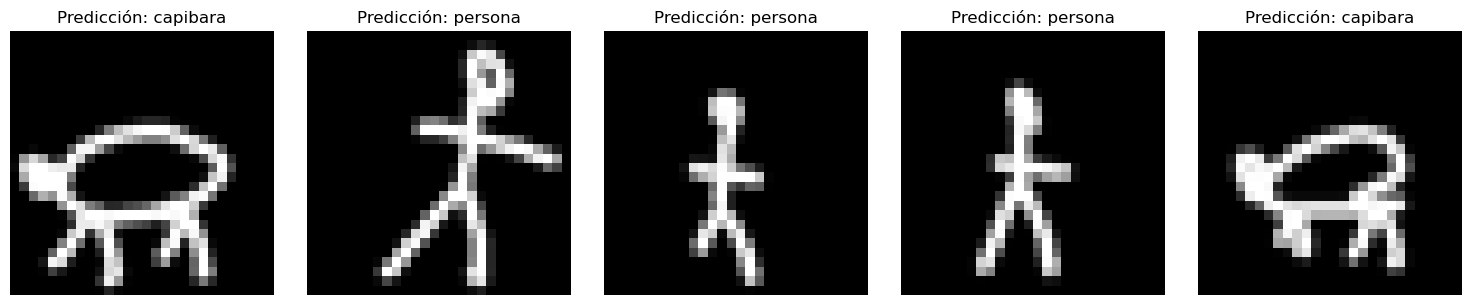

In [59]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import torch
import os

# Definir nombres de las clases
class_names = ['capibara', 'persona']

# Función para cargar y procesar la imagen
def load_and_process_image(img_path):
    img = Image.open(img_path).convert('L')  # Convertir a escala de grises
    img = img.resize((28, 28))  # Redimensionar a 28x28
    img_tensor = transform(img).unsqueeze(0)
    return img, img_tensor

# Función para mostrar una cuadrícula de imágenes
def show_image_grid(images, preds):
    num_images = len(images)
    num_cols = min(num_images, 5)  # Máximo de 5 imágenes por fila
    num_rows = (num_images + num_cols - 1) // num_cols  # Calcular número de filas
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    
    # Convertir ejes a una lista si solo hay una fila
    if num_rows == 1:
        axes = [axes]
    
    # Aplanar la lista de ejes si hay múltiples filas
    axes = [ax for sublist in axes for ax in sublist]

    for ax, (img, pred) in zip(axes, zip(images, preds)):
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Predicción: {class_names[pred]}', fontsize=12)
        ax.axis('off')

    # Ocultar ejes que no tengan imágenes asignadas
    for ax in axes[len(images):]:
        ax.axis('off')

    plt.tight_layout()  # Ajustar el layout para evitar solapamientos
    plt.show()

# Configura la transformación para normalizar las imágenes
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Carpeta local con imágenes para prueba
test_dir = '/tmp/imagenes_prueba3'

# Cargar y procesar imágenes para prueba
images = []
preds = []

for img_file in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_file)
    img, img_tensor = load_and_process_image(img_path)

    # Mostrar la imagen
    images.append(img)

    # Hacer predicción
    model.eval()
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)
    preds.append(predicted.item())

# Mostrar imágenes con las predicciones
show_image_grid(images, preds)


In [61]:
!git init
!git add "Prueba 3 Personas vs Capibaras.ipynb"

Reinitialized existing Git repository in /home/ec2-user/SageMaker/Sagemaker2/.git/


In [62]:
!git commit -m "funcionaron los capibaraaaaaasssss wiii :3"

[main d172378] funcionaron los capibaraaaaaasssss wiii :3
 Committer: EC2 Default User <ec2-user@ip-172-16-9-8.us-west-2.compute.internal>
Your name and email address were configured automatically based
on your username and hostname. Please check that they are accurate.
You can suppress this message by setting them explicitly:

    git config --global user.name "Your Name"
    git config --global user.email you@example.com

After doing this, you may fix the identity used for this commit with:

    git commit --amend --reset-author

 1 file changed, 1683 insertions(+)
 create mode 100644 Prueba 3 Personas vs Capibaras.ipynb


In [63]:
import boto3
import os

s3 = boto3.client('s3')
bucket_name = 'buchetchan'
s3_folder = 'Prueba3/'
local_folder = '/tmp/imagenes_prueba3/'

# Crear directorio local si no existe
os.makedirs(local_folder, exist_ok=True)

# Listar y descargar los archivos desde S3
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=s3_folder)

if 'Contents' in response:
    for obj in response['Contents']:
        s3_file_path = obj['Key']
        if not s3_file_path.endswith('/'):  # Evitar directorios
            local_file_path = os.path.join(local_folder, os.path.basename(s3_file_path))
            s3.download_file(bucket_name, s3_file_path, local_file_path)
            print(f'Descargado {local_file_path}')
else:
    print(f"No se encontraron archivos en {s3_folder}")

Descargado /tmp/imagenes_prueba3/1.png
Descargado /tmp/imagenes_prueba3/2.png
Descargado /tmp/imagenes_prueba3/3.png
Descargado /tmp/imagenes_prueba3/4.png
Descargado /tmp/imagenes_prueba3/5.png
Descargado /tmp/imagenes_prueba3/6.png
Descargado /tmp/imagenes_prueba3/7.png


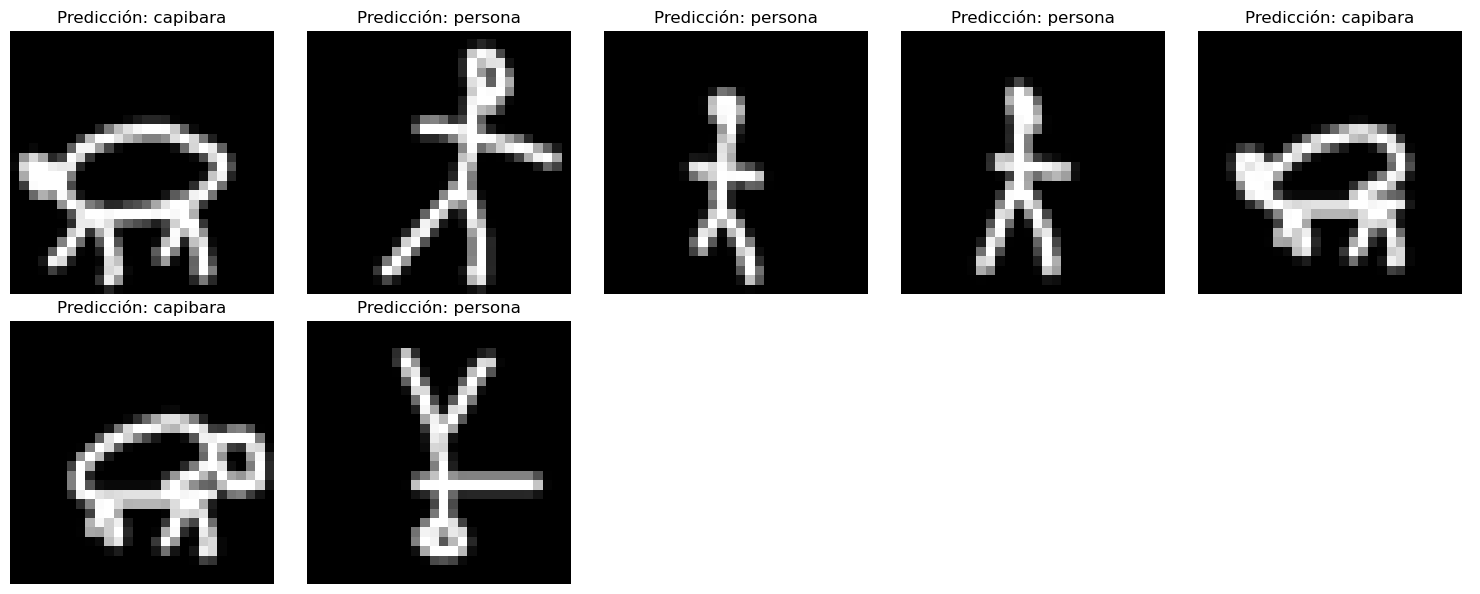

In [64]:
###      Éste funciona!!!!

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import torch
import os

# Definir nombres de las clases
class_names = ['capibara', 'persona']

# Función para cargar y procesar la imagen
def load_and_process_image(img_path):
    img = Image.open(img_path).convert('L')  # Convertir a escala de grises
    img = img.resize((28, 28))  # Redimensionar a 28x28
    img_tensor = transform(img).unsqueeze(0)
    return img, img_tensor

# Función para mostrar una cuadrícula de imágenes
def show_image_grid(images, preds):
    num_images = len(images)
    num_cols = min(num_images, 5)  # Máximo de 5 imágenes por fila
    num_rows = (num_images + num_cols - 1) // num_cols  # Calcular número de filas
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    
    # Convertir ejes a una lista si solo hay una fila
    if num_rows == 1:
        axes = [axes]
    
    # Aplanar la lista de ejes si hay múltiples filas
    axes = [ax for sublist in axes for ax in sublist]

    for ax, (img, pred) in zip(axes, zip(images, preds)):
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Predicción: {class_names[pred]}', fontsize=12)
        ax.axis('off')

    # Ocultar ejes que no tengan imágenes asignadas
    for ax in axes[len(images):]:
        ax.axis('off')

    plt.tight_layout()  # Ajustar el layout para evitar solapamientos
    plt.show()

# Configura la transformación para normalizar las imágenes
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Carpeta local con imágenes para prueba
test_dir = '/tmp/imagenes_prueba3'

# Cargar y procesar imágenes para prueba
images = []
preds = []

for img_file in os.listdir(test_dir):
    img_path = os.path.join(test_dir, img_file)
    img, img_tensor = load_and_process_image(img_path)

    # Mostrar la imagen
    images.append(img)

    # Hacer predicción
    model.eval()
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)
    preds.append(predicted.item())

# Mostrar imágenes con las predicciones
show_image_grid(images, preds)